# Part 2: Hybrid Recommendation System

Data: MovieLens 1M

Environment: Colab

Description: Load, process and prepare the data in Spark, do the basic EDA; Build a Collaborative Filtering Component (ALS); Build a Content-Based Component (TF-IDF + LSH); Build the recommendation fusion strategy; Evaluate the final system and its components separately using Precision@K, Recall@K, and NDCG@K. Additionally evaluate the training and inference time of the system and its components.

Technologies: Apache Spark (PySpark), Spark MLlib, Spark ML feature engineering (TF-IDF, hashing, LSH). Not Pandas/Scikit-learn for the main pipeline.

**Team Structure:**
- Mykyta Berehulia: Infrastructure, Data Loading, Fusion & Evaluation, GBT Re-Ranking
- Oleksandr Sobetskyi: Collaborative Filtering (ALS)
- Vlad Kolyadyuk: Content-Based Filtering (TF-IDF + LSH)

## 1. Setup

### 1.1 Imports

In [2]:
import os
import sys
import urllib.request
import zipfile
from math import log2

import matplotlib.pyplot as plt

# Fix for Windows
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, FloatType, StructType, StructField

### 1.2 Download Data

In [3]:
DATA_URL = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
DATA_DIR = "data"
DATASET_DIR = os.path.join(DATA_DIR, "ml-1m")
ZIP_PATH = os.path.join(DATA_DIR, "ml-1m.zip")

In [4]:
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

In [5]:
if not os.path.exists(DATASET_DIR):

    if not os.path.exists(ZIP_PATH):
        print("Downloading MovieLens ml-1m...")
        urllib.request.urlretrieve(DATA_URL, ZIP_PATH)

    print("Extracting...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)

### 1.3 Spark Session

In [6]:
spark = SparkSession.builder.appName("MMDS") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.sql.shuffle.partitions", "20") \
    .config("spark.default.parallelism", "20") \
    .config("spark.driver.maxResultSize", "8g") \
    .config("spark.sql.autoBroadcastJoinThreshold", "400m") \
    .config("spark.driver.extraJavaOptions", "-Xss16m") \
    .config("spark.executor.extraJavaOptions", "-Xss16m") \
    .getOrCreate()

### 1.4 Load Data

In [7]:
users_df = spark.read.text(os.path.join(DATASET_DIR, "users.dat")).select(
    F.split(F.col("value"), "::").getItem(0).cast(IntegerType()).alias("user_id"),
    F.split(F.col("value"), "::").getItem(1).alias("gender"),
    F.split(F.col("value"), "::").getItem(2).cast(IntegerType()).alias("age"),
    F.split(F.col("value"), "::").getItem(3).cast(IntegerType()).alias("occupation"),
    F.split(F.col("value"), "::").getItem(4).alias("zip_code")
)
users_df.count()

6040

In [8]:
items_df = spark.read.text(os.path.join(DATASET_DIR, "movies.dat")).select(
    F.split(F.col("value"), "::").getItem(0).cast(IntegerType()).alias("item_id"),
    F.split(F.col("value"), "::").getItem(1).alias("title"),
    F.split(F.col("value"), "::").getItem(2).alias("genres")
)
items_df.count()

3883

In [9]:
ratings_df = spark.read.text(os.path.join(DATASET_DIR, "ratings.dat")).select(
    F.split(F.col("value"), "::").getItem(0).cast(IntegerType()).alias("user_id"),
    F.split(F.col("value"), "::").getItem(1).cast(IntegerType()).alias("item_id"),
    F.split(F.col("value"), "::").getItem(2).cast(FloatType()).alias("rating"),
    F.split(F.col("value"), "::").getItem(3).cast(IntegerType()).alias("timestamp")
)
ratings_df.count()

1000209

In [10]:
users_df.show(5)

+-------+------+---+----------+--------+
|user_id|gender|age|occupation|zip_code|
+-------+------+---+----------+--------+
|      1|     F|  1|        10|   48067|
|      2|     M| 56|        16|   70072|
|      3|     M| 25|        15|   55117|
|      4|     M| 45|         7|   02460|
|      5|     M| 25|        20|   55455|
+-------+------+---+----------+--------+
only showing top 5 rows


In [11]:
items_df.show(5)

+-------+--------------------+--------------------+
|item_id|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Animation|Childre...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|        Comedy|Drama|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows


In [12]:
ratings_df.show(5)

+-------+-------+------+---------+
|user_id|item_id|rating|timestamp|
+-------+-------+------+---------+
|      1|   1193|   5.0|978300760|
|      1|    661|   3.0|978302109|
|      1|    914|   3.0|978301968|
|      1|   3408|   4.0|978300275|
|      1|   2355|   5.0|978824291|
+-------+-------+------+---------+
only showing top 5 rows


## 2. Exploratory Data Analysis

### 2.1 Rating matrix

In [13]:
num_users = users_df.count()
num_items = items_df.count()
num_ratings = ratings_df.count()
sparsity = (1 - (num_ratings / (num_users * num_items))) * 100

print(f"Users:            {num_users:,}")
print(f"Movies:           {num_items:,}")
print(f"Ratings:          {num_ratings:,}")
print(f"Sparsity:         {sparsity:.2f}%")
print(f"Avg ratings/user: {num_ratings/num_users:.1f}")
print(f"Avg ratings/movie:{num_ratings/num_items:.1f}")

Users:            6,040
Movies:           3,883
Ratings:          1,000,209
Sparsity:         95.74%
Avg ratings/user: 165.6
Avg ratings/movie:257.6


### 2.2 Rating distribution

In [14]:
ratings_df.groupBy("rating").count().orderBy("rating").show()

+------+------+
|rating| count|
+------+------+
|   1.0| 56174|
|   2.0|107557|
|   3.0|261197|
|   4.0|348971|
|   5.0|226310|
+------+------+



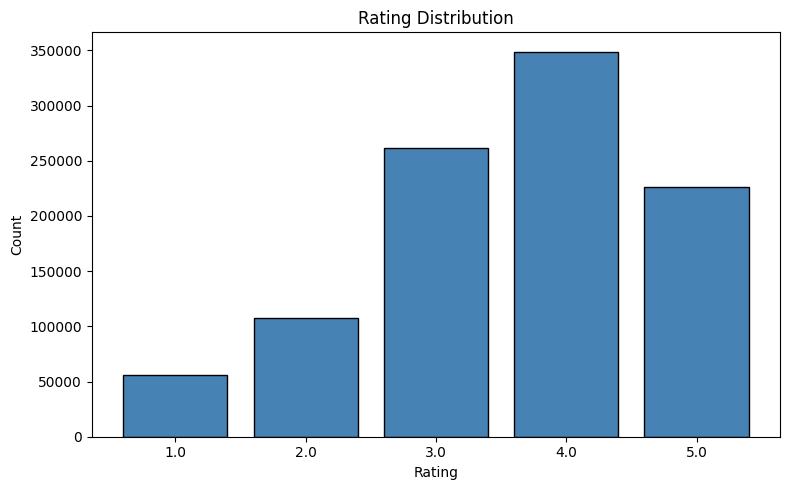

In [15]:
rating_counts = ratings_df.groupBy("rating").count().orderBy("rating").toPandas()
plt.figure(figsize=(8, 5))
plt.bar(rating_counts["rating"].astype(str), rating_counts["count"], color="steelblue", edgecolor="black")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Rating Distribution")
plt.tight_layout()
plt.show()

### 2.3 User activity distribution

In [16]:
user_activity = ratings_df.groupBy("user_id").count().withColumnRenamed("count", "num_ratings")
user_activity.describe().show()

+-------+-----------------+------------------+
|summary|          user_id|       num_ratings|
+-------+-----------------+------------------+
|  count|             6040|              6040|
|   mean|           3020.5| 165.5975165562914|
| stddev|1743.742144546224|192.74702906977762|
|    min|                1|                20|
|    max|             6040|              2314|
+-------+-----------------+------------------+



In [17]:
user_activity.withColumn(
    "activity_bucket",
    F.when(F.col("num_ratings") < 20, "01: <20")
     .when(F.col("num_ratings") < 50, "02: 20-49")
     .when(F.col("num_ratings") < 100, "03: 50-99")
     .when(F.col("num_ratings") < 200, "04: 100-199")
     .otherwise("05: 200+")
).groupBy("activity_bucket").count().orderBy("activity_bucket").show()

+---------------+-----+
|activity_bucket|count|
+---------------+-----+
|      02: 20-49| 1743|
|      03: 50-99| 1352|
|    04: 100-199| 1356|
|       05: 200+| 1589|
+---------------+-----+



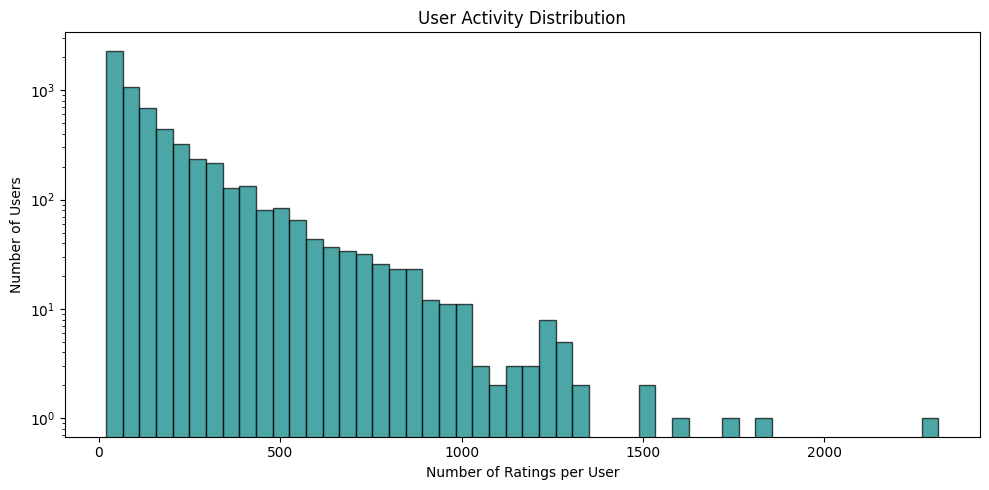

In [18]:
user_ratings_pd = user_activity.select("num_ratings").toPandas()
plt.figure(figsize=(10, 5))
plt.hist(user_ratings_pd["num_ratings"], bins=50, color="teal", edgecolor="black", alpha=0.7)
plt.xlabel("Number of Ratings per User")
plt.ylabel("Number of Users")
plt.title("User Activity Distribution")
plt.yscale("log")
plt.tight_layout()
plt.show()

### 2.4 Item activity distribution

In [19]:
item_activity = ratings_df.groupBy("item_id").count().withColumnRenamed("count", "num_ratings")
item_activity.describe().show()

+-------+------------------+------------------+
|summary|           item_id|       num_ratings|
+-------+------------------+------------------+
|  count|              3706|              3706|
|   mean|1995.5731246627092|269.88909875876953|
| stddev|1151.1480449998328|384.04783757202546|
|    min|                 1|                 1|
|    max|              3952|              3428|
+-------+------------------+------------------+



In [20]:
percentiles = item_activity.approxQuantile("num_ratings", [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99], 0.01)
print(f"Item rating percentiles [10%, 25%, 50%, 75%, 90%, 95%, 99%]: {percentiles}")

Item rating percentiles [10%, 25%, 50%, 75%, 90%, 95%, 99%]: [7.0, 33.0, 122.0, 338.0, 696.0, 972.0, 3428.0]


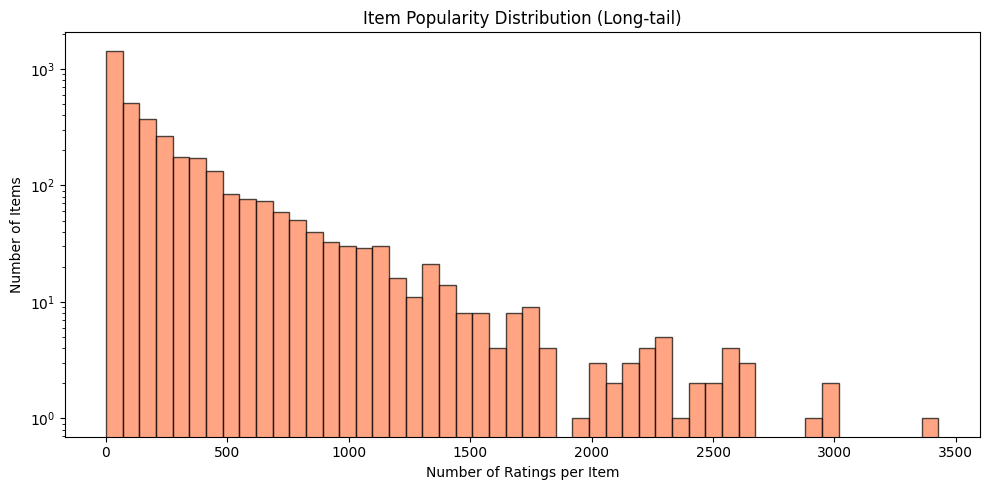

In [21]:
item_ratings_pd = item_activity.select("num_ratings").toPandas()
plt.figure(figsize=(10, 5))
plt.hist(item_ratings_pd["num_ratings"], bins=50, color="coral", edgecolor="black", alpha=0.7)
plt.xlabel("Number of Ratings per Item")
plt.ylabel("Number of Items")
plt.title("Item Popularity Distribution (Long-tail)")
plt.yscale("log")
plt.tight_layout()
plt.show()

### 2.5 Temporal dynamics

In [22]:
temporal_df = ratings_df.withColumn("year_month", F.date_format(F.from_unixtime("timestamp"), "yyyy-MM"))
temporal_df.groupBy("year_month").agg(
    F.count("*").alias("num_ratings"),
    F.avg("rating").alias("avg_rating")
).orderBy("year_month").show(10)

+----------+-----------+------------------+
|year_month|num_ratings|        avg_rating|
+----------+-----------+------------------+
|   2000-04|      11239| 3.551917430376368|
|   2000-05|      66606|3.6176320451610966|
|   2000-06|      54679| 3.625322335814481|
|   2000-07|      90213|3.6334785452207554|
|   2000-08|     182729|3.5717975800228756|
|   2000-09|      51962| 3.603825872753166|
|   2000-10|      42994|3.6259478066706983|
|   2000-11|     290273|3.5720511380665787|
|   2000-12|     113856| 3.583956928049466|
|   2001-01|      18200|3.5465384615384616|
+----------+-----------+------------------+
only showing top 10 rows


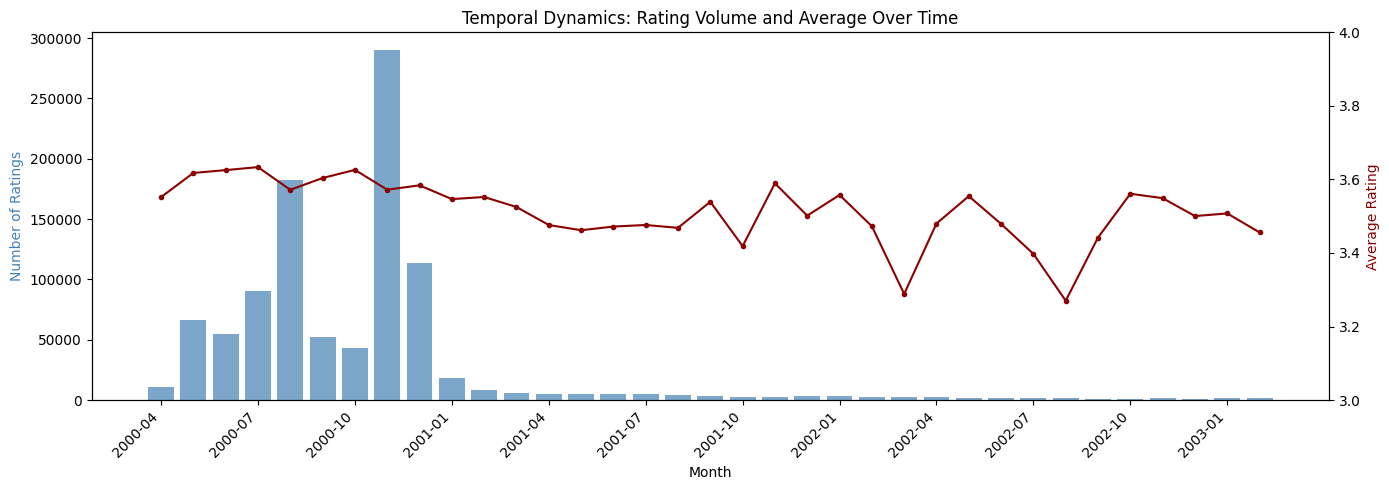

In [23]:
temporal_pd = temporal_df.groupBy("year_month").agg(
    F.count("*").alias("num_ratings"),
    F.avg("rating").alias("avg_rating")
).orderBy("year_month").toPandas()

fig, ax1 = plt.subplots(figsize=(14, 5))
ax1.bar(range(len(temporal_pd)), temporal_pd["num_ratings"], color="steelblue", alpha=0.7, label="Ratings Count")
ax1.set_xlabel("Month")
ax1.set_ylabel("Number of Ratings", color="steelblue")
ax1.set_xticks(range(0, len(temporal_pd), 3))
ax1.set_xticklabels(temporal_pd["year_month"].iloc[::3], rotation=45, ha="right")

ax2 = ax1.twinx()
ax2.plot(range(len(temporal_pd)), temporal_pd["avg_rating"], color="darkred", marker="o", markersize=3, label="Avg Rating")
ax2.set_ylabel("Average Rating", color="darkred")
ax2.set_ylim(3.0, 4.0)

plt.title("Temporal Dynamics: Rating Volume and Average Over Time")
plt.tight_layout()
plt.show()

### 2.6 Data pathologies

#### 2.6.1 Popularity skew

In [24]:
item_popularity = item_activity.orderBy(F.desc("num_ratings"))
window_spec = Window.orderBy(F.desc("num_ratings"))
item_cumulative = item_popularity.withColumn("rank", F.row_number().over(window_spec)) \
    .withColumn("cumsum", F.sum("num_ratings").over(Window.orderBy(F.desc("num_ratings")).rowsBetween(Window.unboundedPreceding, 0)))

total_ratings = num_ratings
top_10_pct = item_cumulative.filter(F.col("rank") <= num_items * 0.1).agg(F.max("cumsum")).collect()[0][0]
top_20_pct = item_cumulative.filter(F.col("rank") <= num_items * 0.2).agg(F.max("cumsum")).collect()[0][0]

print(f"Top 10% of items account for {top_10_pct/total_ratings*100:.1f}% of all ratings")
print(f"Top 20% of items account for {top_20_pct/total_ratings*100:.1f}% of all ratings")

Top 10% of items account for 45.7% of all ratings
Top 20% of items account for 66.6% of all ratings


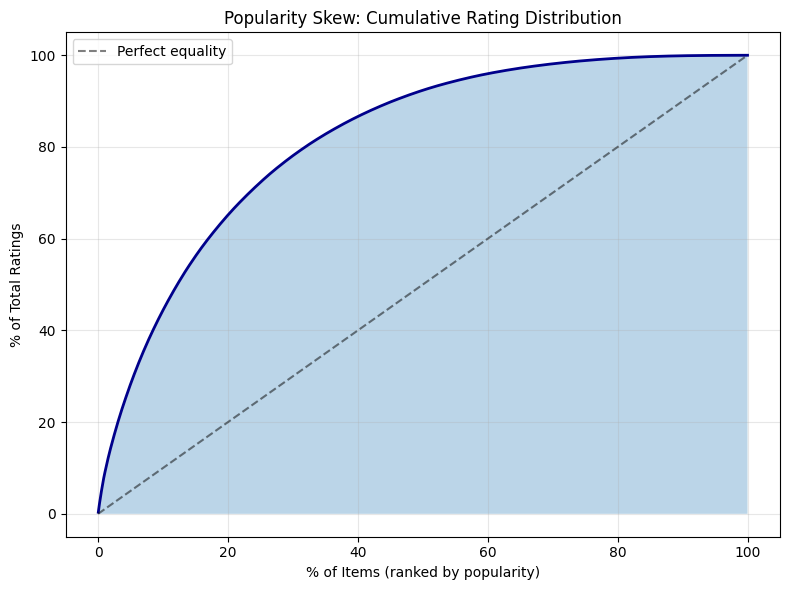

In [25]:
item_cum_pd = item_cumulative.orderBy("rank").select("rank", "cumsum").toPandas()
item_cum_pd["cum_pct"] = item_cum_pd["cumsum"] / total_ratings * 100
item_cum_pd["item_pct"] = item_cum_pd["rank"] / len(item_cum_pd) * 100

plt.figure(figsize=(8, 6))
plt.plot(item_cum_pd["item_pct"], item_cum_pd["cum_pct"], color="darkblue", linewidth=2)
plt.plot([0, 100], [0, 100], "k--", alpha=0.5, label="Perfect equality")
plt.fill_between(item_cum_pd["item_pct"], item_cum_pd["cum_pct"], alpha=0.3)
plt.xlabel("% of Items (ranked by popularity)")
plt.ylabel("% of Total Ratings")
plt.title("Popularity Skew: Cumulative Rating Distribution")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### 2.6.2 Cold-start problem

In [26]:
cold_users = user_activity.filter(F.col("num_ratings") < 50).count()
cold_items = item_activity.filter(F.col("num_ratings") < 50).count()

print(f"Cold-start users (<50 ratings): {cold_users:,} ({cold_users/num_users*100:.1f}%)")
print(f"Cold-start items (<50 ratings): {cold_items:,} ({cold_items/num_items*100:.1f}%)")

Cold-start users (<50 ratings): 1,743 (28.9%)
Cold-start items (<50 ratings): 1,192 (30.7%)


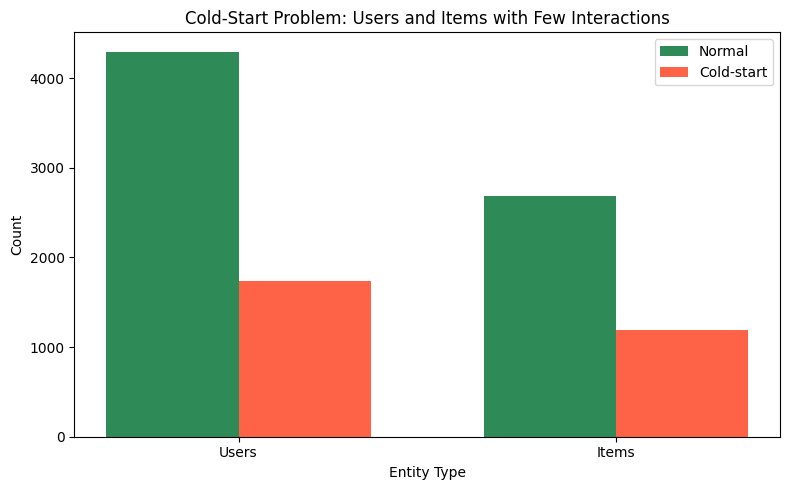

In [27]:
categories = ["Users", "Items"]
cold_counts = [cold_users, cold_items]
total_counts = [num_users, num_items]
normal_counts = [num_users - cold_users, num_items - cold_items]

x = range(len(categories))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar([i - width/2 for i in x], normal_counts, width, label="Normal", color="seagreen")
plt.bar([i + width/2 for i in x], cold_counts, width, label="Cold-start", color="tomato")
plt.xlabel("Entity Type")
plt.ylabel("Count")
plt.title("Cold-Start Problem: Users and Items with Few Interactions")
plt.xticks(x, categories)
plt.legend()
plt.tight_layout()
plt.show()

### 2.7 Genre distribution

In [28]:
items_df.select(F.explode(F.split(F.col("genres"), "\\|")).alias("genre")).groupBy("genre").count().orderBy(F.desc("count")).show()

+-----------+-----+
|      genre|count|
+-----------+-----+
|      Drama| 1603|
|     Comedy| 1200|
|     Action|  503|
|   Thriller|  492|
|    Romance|  471|
|     Horror|  343|
|  Adventure|  283|
|     Sci-Fi|  276|
| Children's|  251|
|      Crime|  211|
|        War|  143|
|Documentary|  127|
|    Musical|  114|
|    Mystery|  106|
|  Animation|  105|
|    Western|   68|
|    Fantasy|   68|
|  Film-Noir|   44|
+-----------+-----+



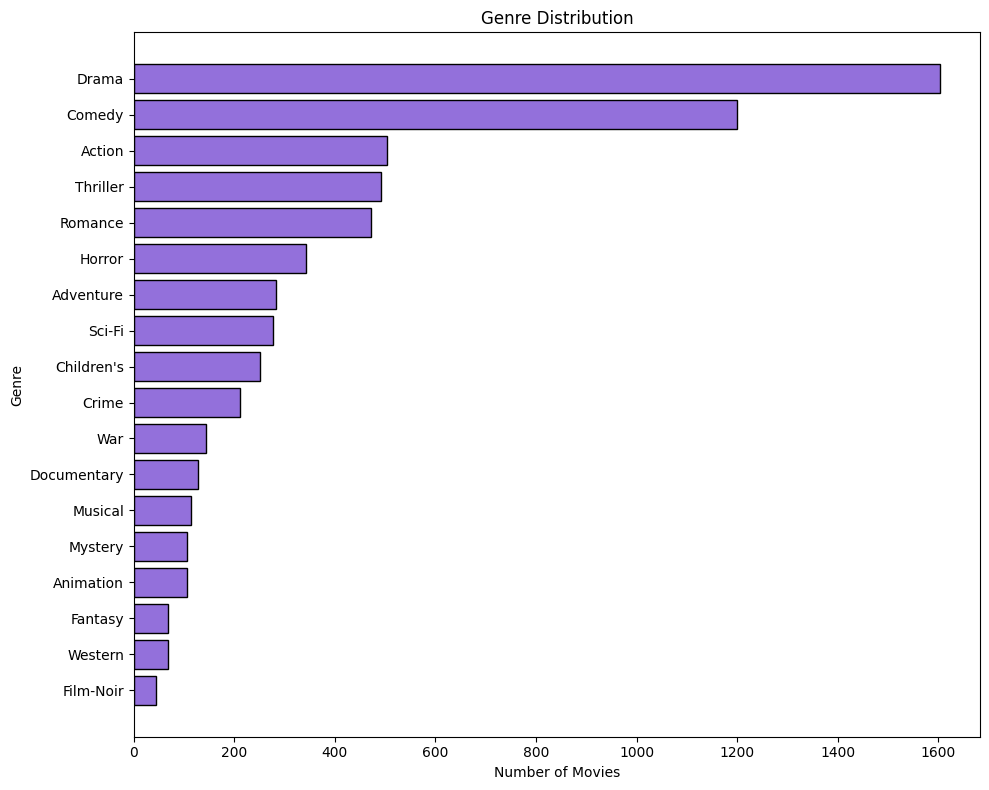

In [29]:
genre_pd = items_df.select(F.explode(F.split(F.col("genres"), "\\|")).alias("genre")) \
    .groupBy("genre").count().orderBy("count").toPandas()

plt.figure(figsize=(10, 8))
plt.barh(genre_pd["genre"], genre_pd["count"], color="mediumpurple", edgecolor="black")
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.title("Genre Distribution")
plt.tight_layout()
plt.show()

### 2.8 User gender distribution

In [30]:
users_df.groupBy("gender").count().show()

+------+-----+
|gender|count|
+------+-----+
|     F| 1709|
|     M| 4331|
+------+-----+



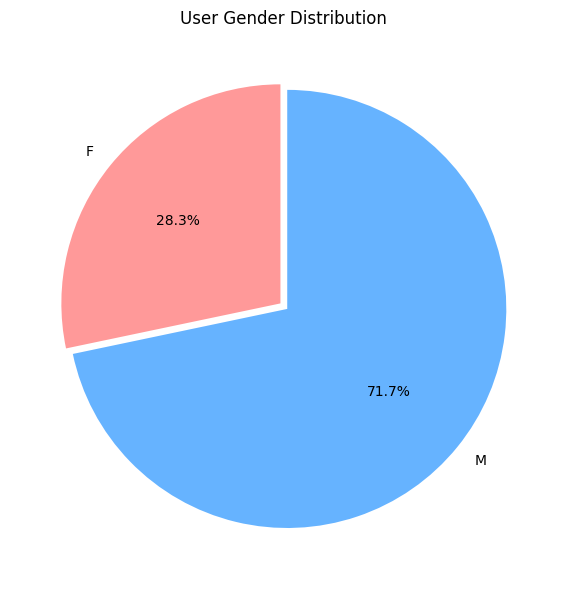

In [31]:
gender_pd = users_df.groupBy("gender").count().toPandas()
plt.figure(figsize=(6, 6))
colors = ["#ff9999", "#66b3ff"]
plt.pie(gender_pd["count"], labels=gender_pd["gender"], autopct="%1.1f%%", colors=colors, startangle=90, explode=(0.02, 0.02))
plt.title("User Gender Distribution")
plt.tight_layout()
plt.show()

### 2.9 User age distribution

In [32]:
users_df.groupBy("age").count().orderBy("age").show()

+---+-----+
|age|count|
+---+-----+
|  1|  222|
| 18| 1103|
| 25| 2096|
| 35| 1193|
| 45|  550|
| 50|  496|
| 56|  380|
+---+-----+



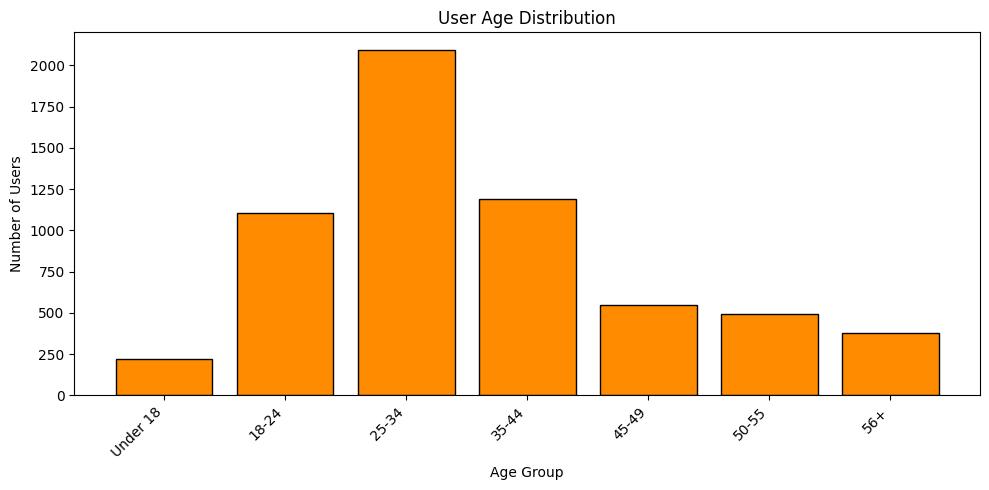

In [33]:
age_labels = {1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44", 45: "45-49", 50: "50-55", 56: "56+"}
age_pd = users_df.groupBy("age").count().orderBy("age").toPandas()
age_pd["age_label"] = age_pd["age"].map(age_labels)

plt.figure(figsize=(10, 5))
plt.bar(age_pd["age_label"], age_pd["count"], color="darkorange", edgecolor="black")
plt.xlabel("Age Group")
plt.ylabel("Number of Users")
plt.title("User Age Distribution")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 3. Train/Test Split

In [17]:
def chronological_split(ratings_df, train_ratio=0.8, min_train_ratings=5):
    user_time_window = Window.partitionBy("user_id").orderBy("timestamp")
    user_count_window = Window.partitionBy("user_id")

    ratings_with_rank = ratings_df.withColumn(
        "row_num", F.row_number().over(user_time_window)
    ).withColumn(
        "user_total", F.count("*").over(user_count_window)
    ).withColumn(
        "train_threshold", F.floor(F.col("user_total") * train_ratio)
    )

    ratings_valid = ratings_with_rank.filter(
        F.col("train_threshold") >= min_train_ratings
    )

    ratings_labeled = ratings_valid.withColumn(
        "split",
        F.when(F.col("row_num") <= F.col("train_threshold"), "train").otherwise("test")
    )

    original_columns = ["user_id", "item_id", "rating", "timestamp"]
    train_df = ratings_labeled.filter(F.col("split") == "train").select(original_columns)
    test_df = ratings_labeled.filter(F.col("split") == "test").select(original_columns)

    return train_df, test_df

In [18]:
train_df, test_df = chronological_split(ratings_df, train_ratio=0.8, min_train_ratings=5)
train_df = train_df.cache()
test_df = test_df.cache()

In [19]:
print(f"Train: {train_df.count():,} ratings")
print(f"Test: {test_df.count():,} ratings")
print(f"Users in train: {train_df.select('user_id').distinct().count():,}")
print(f"Users in test: {test_df.select('user_id').distinct().count():,}")

Train: 797,758 ratings
Test: 202,451 ratings
Users in train: 6,040
Users in test: 6,040


## 4. Evaluation Code


### 4.1 Hyperparameters

In [20]:
K = 10
RELEVANCE_THRESHOLD = 4.0

### 4.2 Ground Truth

In [21]:
ground_truth = test_df.filter(F.col("rating") >= RELEVANCE_THRESHOLD) \
    .groupBy("user_id").agg(F.collect_list("item_id").alias("relevant_items"))

### 4.3 Functions

In [22]:
def get_top_k(recs_df, score_col, k):
    window = Window.partitionBy("user_id").orderBy(F.desc(score_col))
    ranked = recs_df.withColumn("rank", F.row_number().over(window)) \
        .filter(F.col("rank") <= k)

    return ranked.groupBy("user_id").agg(
        F.array_sort(F.collect_list(F.struct("rank", "item_id"))).alias("ranked_structs")
    ).withColumn(
        "recommended_items",
        F.expr("transform(ranked_structs, x -> x.item_id)")
    ).drop("ranked_structs")

In [23]:
def precision_at_k(top_k_df, ground_truth_df, k):
    joined = top_k_df.join(ground_truth_df, "user_id")
    result = joined.withColumn("hits", F.size(F.array_intersect("recommended_items", "relevant_items"))) \
        .agg(F.avg(F.col("hits") / k)).collect()[0][0]
    return result or 0.0

In [24]:
def recall_at_k(top_k_df, ground_truth_df):
    joined = top_k_df.join(ground_truth_df, "user_id")
    result = joined.withColumn("hits", F.size(F.array_intersect("recommended_items", "relevant_items"))) \
        .withColumn("recall", F.when(F.size("relevant_items") > 0, F.col("hits") / F.size("relevant_items")).otherwise(0)) \
        .agg(F.avg("recall")).collect()[0][0]
    return result or 0.0

In [25]:
def ndcg_at_k(top_k_df, ground_truth_df, k):
    joined = top_k_df.join(ground_truth_df, "user_id")
    exploded = joined.select(
        "user_id",
        "relevant_items",
        F.posexplode("recommended_items").alias("pos", "item_id")
    ).withColumn("item_id", F.col("item_id").cast(IntegerType()))

    with_dcg = exploded \
        .withColumn("rel", F.when(F.array_contains("relevant_items", F.col("item_id")), 1.0).otherwise(0.0)) \
        .withColumn("dcg", F.col("rel") / F.log2(F.col("pos") + 2)) \
        .groupBy("user_id", "relevant_items").agg(F.sum("dcg").alias("dcg"))

    idcg_vals = [sum(1.0 / log2(i + 2) for i in range(n)) for n in range(k + 1)]
    idcg_map = F.create_map(*[x for i, v in enumerate(idcg_vals) for x in (F.lit(i), F.lit(v))])

    result = with_dcg \
        .withColumn("num_rel", F.least(F.size("relevant_items"), F.lit(k))) \
        .withColumn("idcg", idcg_map[F.col("num_rel")]) \
        .withColumn("ndcg", F.when(F.col("idcg") > 0, F.col("dcg") / F.col("idcg")).otherwise(0)) \
        .agg(F.avg("ndcg")).collect()[0][0]
    return result or 0.0

In [26]:
def evaluate(recs_df, score_col, name):
    if recs_df.count() == 0:
        print(f"{name}: No recommendations (not implemented)")
        return {"Precision@10": 0.0, "Recall@10": 0.0, "NDCG@10": 0.0}

    top_k = get_top_k(recs_df, score_col, K)
    p = precision_at_k(top_k, ground_truth, K)
    r = recall_at_k(top_k, ground_truth)
    n = ndcg_at_k(top_k, ground_truth, K)

    print(f"{name}: P@{K}={p:.4f}, R@{K}={r:.4f}, NDCG@{K}={n:.4f}")
    return {"Precision@10": p, "Recall@10": r, "NDCG@10": n}

## 5. Collaborative Filtering (ALS)

Implement using `pyspark.ml.recommendation.ALS`

In [27]:
class CollaborativeFilter:

    def __init__(self, rank=10, regParam=0.1, maxIter=10):
        self.als = ALS(
            userCol="user_id",
            itemCol="item_id",
            ratingCol="rating",
            rank=rank,
            regParam=regParam,
            maxIter=maxIter,
            coldStartStrategy="drop",
            nonnegative=True
        )
        self.model = None

    def train(self, df):
        self.model = self.als.fit(df)

    def get_recommendations(self, df, k=10):
        """Get top-K recommendations"""
        if self.model is None:
            raise ValueError("Call train() first.")

        users = df.select("user_id").distinct()
        user_recs = self.model.recommendForUserSubset(users, k)

        return user_recs.select(
            F.col("user_id"),
            F.explode("recommendations").alias("rec")
        ).select(
            F.col("user_id"),
            F.col("rec.item_id").cast(IntegerType()).alias("item_id"),
            F.col("rec.rating").alias("prediction")
        )

    def predict(self, df):
        """Predict ratings for user-item pairs in test"""
        if self.model is None:
            raise ValueError("Train should be called first")
        return self.model.transform(df)

In [28]:
import time

# Best ALS hyperparameters (from tuning - see Appendix)
ALS_RANK = 40
ALS_REG_PARAM = 0.05
ALS_MAX_ITER = 30

cf = CollaborativeFilter(rank=ALS_RANK, regParam=ALS_REG_PARAM, maxIter=ALS_MAX_ITER)

t0 = time.perf_counter()
cf.train(train_df)
als_train_s = time.perf_counter() - t0

t0 = time.perf_counter()
als_recs = cf.get_recommendations(test_df, k=100).withColumnRenamed("prediction", "als_score").cache()
als_num_recs = als_recs.count()
als_infer_s = time.perf_counter() - t0

print(f"ALS params: rank={ALS_RANK}, regParam={ALS_REG_PARAM}, maxIter={ALS_MAX_ITER}")
print(f"ALS train time: {als_train_s:.2f}s")
print(f"ALS inference time: {als_infer_s:.2f}s | rec rows: {als_num_recs:,}")

ALS params: rank=40, regParam=0.05, maxIter=30
ALS train time: 36.45s
ALS inference time: 7.47s | rec rows: 604,000


In [29]:
als_recs.show(10)

+-------+-------+---------+
|user_id|item_id|als_score|
+-------+-------+---------+
|     95|    260| 4.674539|
|     95|   2618| 4.659611|
|     95|    318|4.5339203|
|     95|   1234| 4.505843|
|     95|   1198| 4.501619|
|     95|   2028| 4.496494|
|     95|    110| 4.477159|
|     95|    356|4.4259267|
|     95|   2804| 4.403953|
|     95|   2762|4.3927045|
+-------+-------+---------+
only showing top 10 rows


## 6. Content-Based Filtering (TF-IDF + LSH)

Implement using `pyspark.ml.feature` (Tokenizer, HashingTF, IDF, BucketedRandomProjectionLSH)

In [30]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, NGram, MinHashLSH
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import (
    col, split, concat_ws, regexp_extract, udf, array_intersect, 
    size, sum as _sum, desc, row_number
)

class ContentBasedFilter:
    def __init__(self, num_features=5000, bigram_features=3000, num_hash_tables=10):
        self.num_features = num_features
        self.bigram_features = bigram_features
        self.num_hash_tables = num_hash_tables
        self.jaccard_threshold = 0.1
        self.genre_weight = 4
        self.min_genre_overlap = 1
        

        self.lsh_model = None
        self.vector_model = None
        self.movies_binary = None
        self.similar_pairs = None

    def combine_binarize_udf(self):
        def process_vectors(v1, v2):
            if v1 is None: 
                return None
            indices = [int(i) for i in v1.indices]
            
            if v2 is not None:
                offset = int(v1.size)
                indices += [int(i) + offset for i in v2.indices]
                total_size = offset + int(v2.size)
            else:
                total_size = int(v1.size)
            
            values = [1.0] * len(indices)
            return Vectors.sparse(total_size, sorted(indices), values)
            
        return udf(process_vectors, VectorUDT())

    def train_features(self, items_df):
        print("building content features (tfidf + bigrams)")
        
        df = (
            items_df
            .withColumn("year", regexp_extract(col("title"), r"\((\d{4})\)", 1))
            .withColumn("decade", regexp_extract(col("title"), r"\((\d{3})\d\)", 1))
            .withColumn("genres_spaced", F.regexp_replace(col("genres"), r"\|", " "))
            .withColumn("content", concat_ws(
                " ", 
                col("title"),
                col("genres_spaced"), col("genres_spaced"), col("genres_spaced"), col("genres_spaced"),
                col("year"), col("decade")
            ))
        )

        stages = []

        stages += [
            Tokenizer(inputCol="content", outputCol="raw_words"),
            StopWordsRemover(inputCol="raw_words", outputCol="words")
        ]
        
        stages += [
            HashingTF(inputCol="words", outputCol="tf_uni", numFeatures=self.num_features),
            IDF(inputCol="tf_uni", outputCol="tfidf_uni", minDocFreq=1)
        ]
        
        stages += [
            NGram(n=2, inputCol="words", outputCol="bigrams"),
            HashingTF(inputCol="bigrams", outputCol="tf_bi", numFeatures=self.bigram_features),
            IDF(inputCol="tf_bi", outputCol="tfidf_bi", minDocFreq=1)
        ]
        
        pipeline = Pipeline(stages=stages)
        self.vector_model = pipeline.fit(df)
        features_df = self.vector_model.transform(df)
        
        combiner = self.combine_binarize_udf()
        self.movies_binary = (
            features_df
            .withColumn("binary_features", combiner("tfidf_uni", "tfidf_bi"))
            .select("item_id", "title", "genres", "binary_features")
            .cache()
        )
        
        print(f"checked {self.movies_binary.count()} movies")

    def build_lsh_index(self):
        print("indexing with minhash LSH")
        
        mh = MinHashLSH(
            inputCol="binary_features", 
            outputCol="hashes", 
            numHashTables=self.num_hash_tables,
            seed=42
        )
        self.lsh_model = mh.fit(self.movies_binary)
        
        dist_threshold = 1.0 - self.jaccard_threshold
        
        print(f"cmputing similarity graph")
        raw_pairs = self.lsh_model.approxSimilarityJoin(
            self.movies_binary, self.movies_binary, 
            threshold=dist_threshold, 
            distCol="jaccard_dist"
        )
        
        pairs = raw_pairs.select(
            col("datasetA.item_id").alias("item_a"),
            col("datasetB.item_id").alias("item_b"),
            (1.0 - col("jaccard_dist")).alias("similarity")
        ).filter("item_a != item_b")
        
        self.similar_pairs = pairs.cache()
        print(f"indexed {self.similar_pairs.count()} similar item pairs")

    def recommend_for_users(self, train_df, items_df, k=10):
        print("generating content-based recommendations")
        
        user_history = train_df.filter(col("rating") >= 4.0).select(
            col("user_id"), col("item_id").alias("seed_item"), col("rating")
        )

        candidates = user_history.join(
            self.similar_pairs,
            user_history.seed_item == self.similar_pairs.item_a
        )
        
        genre_df = items_df.select("item_id", split(col("genres"), r"\|").alias("genres_arr"))        
        
        candidates_enriched = (
            candidates.alias("c")
            .join(
                genre_df.alias("seed_g"), 
                col("c.seed_item") == col("seed_g.item_id")
            )
            .join(
                genre_df.alias("cand_g"), 
                col("c.item_b") == col("cand_g.item_id")
            )
            .select(
                "c.user_id", 
                col("c.item_b").alias("candidate_item"),
                "c.rating", 
                "c.similarity",
                size(array_intersect(
                    col("seed_g.genres_arr"), 
                    col("cand_g.genres_arr")
                )).alias("genre_overlap")
            )
        )

        filtered = candidates_enriched.filter(col("genre_overlap") >= self.min_genre_overlap)

        scored = filtered.withColumn(
            "score", 
            col("rating") * col("similarity") * (1.0 + 0.25 * col("genre_overlap"))
        )

        recs = scored.groupBy("user_id", "candidate_item").agg(_sum("score").alias("content_score"))
        
        seen_items = train_df.select("user_id", "item_id").distinct().alias("seen")
        recs_alias = recs.alias("recs")
        
        final_recs = recs_alias.join(
            seen_items,
            (col("recs.user_id") == col("seen.user_id")) & 
            (col("recs.candidate_item") == col("seen.item_id")),
            "left_anti"
        ).select(
            col("recs.user_id"), 
            col("recs.candidate_item").alias("item_id"), 
            col("recs.content_score")
        )

        window = Window.partitionBy("user_id").orderBy(desc("content_score"))
        return (
            final_recs
            .withColumn("rank", row_number().over(window))
            .filter(col("rank") <= k)
            .drop("rank")
        )

cb_filter = ContentBasedFilter()
cb_filter.train_features(items_df)
cb_filter.build_lsh_index()


building content features (tfidf + bigrams)
checked 3883 movies
indexing with minhash LSH
cmputing similarity graph
indexed 988212 similar item pairs


In [31]:
content_recs = cb_filter.recommend_for_users(train_df, items_df, k=100)

generating content-based recommendations


In [32]:
content_recs = content_recs.cache()
content_recs.show(5)

+-------+-------+------------------+
|user_id|item_id|     content_score|
+-------+-------+------------------+
|     95|   1744| 22.83967523704366|
|     95|   1591|22.473956043956044|
|     95|    849|21.873400389932648|
|     95|   2334|21.532246786394385|
|     95|   2058| 21.53224678639438|
+-------+-------+------------------+
only showing top 5 rows


## 7.Fusion & Evaluation

In [33]:
ALPHA = 0.7

### 7.1 Normalization

In [34]:
def normalize(df, col_name):
    stats = df.agg(F.min(col_name).alias("min"), F.max(col_name).alias("max")).collect()[0]
    if stats["max"] == stats["min"]:
        return df.withColumn(col_name + "_norm", F.lit(0.5))
    return df.withColumn(col_name + "_norm", (F.col(col_name) - stats["min"]) / (stats["max"] - stats["min"]))

### 7.2 Hybrid Fusion

In [35]:
als_norm = normalize(als_recs, "als_score")
content_norm = normalize(content_recs, "content_score")

hybrid_recs = als_norm.select("user_id", "item_id", "als_score_norm") \
    .join(content_norm.select("user_id", "item_id", "content_score_norm"), ["user_id", "item_id"], "full_outer") \
    .fillna(0) \
    .withColumn("final_score", ALPHA * F.col("als_score_norm") + (1 - ALPHA) * F.col("content_score_norm"))

In [36]:
hybrid_recs.orderBy(F.desc("final_score")).show(10)

+-------+-------+------------------+--------------------+------------------+
|user_id|item_id|    als_score_norm|  content_score_norm|       final_score|
+-------+-------+------------------+--------------------+------------------+
|   2155|   2964|               1.0|                 0.0|               0.7|
|   4277|     53|0.6587726651983272|   0.590465080351217|0.6382803897441941|
|   3480|    718|0.8983343882862961|                 0.0|0.6288340718004072|
|   4169|   2493|0.5689610624805806|  0.7406185525735851| 0.620458309508482|
|   3052|   2666|0.8772770782885784|0.015282598246651423|0.6186787342760002|
|   5597|    166|0.8784567944543318|                 0.0|0.6149197561180322|
|   4169|     53|0.5689974049916859|  0.7100814164276091|0.6113226084224629|
|   2441|   2128|0.8668098230058501|                 0.0| 0.606766876104095|
|   5328|    532|0.8650956806504744|                 0.0| 0.605566976455332|
|   1069|   1859|0.6927555909510361| 0.39733290535923144|0.6041287852734947|

In [37]:
hybrid_recs.orderBy(F.desc("final_score")).filter((F.col("als_score_norm") > 0.2) & (F.col("content_score_norm") > 0.2)).show(10)

+-------+-------+------------------+-------------------+------------------+
|user_id|item_id|    als_score_norm| content_score_norm|       final_score|
+-------+-------+------------------+-------------------+------------------+
|   4277|     53|0.6587726651983272|  0.590465080351217|0.6382803897441941|
|   4169|   2493|0.5689610624805806| 0.7406185525735851| 0.620458309508482|
|   4169|     53|0.5689974049916859| 0.7100814164276091|0.6113226084224629|
|   1069|   1859|0.6927555909510361|0.39733290535923144|0.6041287852734947|
|   4277|   2579|0.6194772294275183| 0.5430159889973912|0.5965388572984801|
|    195|     53|0.6899149072619453|0.36953719846743455| 0.593801594623592|
|   1448|     53|0.6167054052331533| 0.5233646290001703|0.5887031723632584|
|   1812|   2305|0.7326370210219622|0.24769294234208108|0.5871537974179978|
|   1448|     82|0.6084094428402308| 0.5037712657787663|0.5770179897217914|
|   3539|   2675|0.6180326337387194|0.47138848448326837|0.5740393889620841|
+-------+---

In [38]:
als_pairs = als_recs.select("user_id", "item_id").distinct()
content_pairs = content_recs.select("user_id", "item_id").distinct()

overlap = als_pairs.intersect(content_pairs).count()
print(f"als pairs: {als_pairs.count()}")
print(f"content pairs: {content_pairs.count()}")
print(f"overlap: {overlap}")

als pairs: 604000
content pairs: 603761
overlap: 13051


### 7.3 Evaluation

In [39]:
als_metrics = evaluate(als_recs, "als_score", "ALS")

ALS: P@10=0.0259, R@10=0.0182, NDCG@10=0.0278


In [40]:
content_metrics = evaluate(content_recs, "content_score", "Content-Based")

Content-Based: P@10=0.0150, R@10=0.0167, NDCG@10=0.0188


In [41]:
hybrid_metrics = evaluate(hybrid_recs, "final_score", "Hybrid")

Hybrid: P@10=0.0273, R@10=0.0195, NDCG@10=0.0300


### Bonus: GBT Re-Ranking

In [ ]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.types import DoubleType

ALL_GENRES = [
    "Action", "Adventure", "Animation", "Children's", "Comedy", 
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir",
    "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", 
    "Thriller", "War", "Western"
]

def engineer_user_features(users_df, train_df):
    user_stats = train_df.groupBy("user_id").agg(
        F.avg("rating").alias("user_avg_rating"),
        F.count("*").alias("user_rating_count"),
        F.stddev("rating").alias("user_rating_std")
    ).fillna(0)
    
    gender_indexer = StringIndexer(inputCol="gender", outputCol="gender_idx", handleInvalid="keep")
    age_indexer = StringIndexer(inputCol="age", outputCol="age_idx", handleInvalid="keep")
    occupation_indexer = StringIndexer(inputCol="occupation", outputCol="occupation_idx", handleInvalid="keep")
    
    user_pipeline = Pipeline(stages=[gender_indexer, age_indexer, occupation_indexer])
    users_encoded = user_pipeline.fit(users_df).transform(users_df)
    
    user_features = users_encoded.join(user_stats, "user_id", "left").fillna(0)
    
    return user_features.select(
        "user_id", "gender_idx", "age_idx", "occupation_idx",
        "user_avg_rating", "user_rating_count", "user_rating_std"
    )

def engineer_item_features(items_df, train_df):
    items_with_genres = items_df
    for genre in ALL_GENRES:
        genre_clean = genre.lower().replace("-", "_").replace("'", "")
        col_name = f"genre_{genre_clean}"
        items_with_genres = items_with_genres.withColumn(
            col_name,
            F.when(F.col("genres").contains(genre), 1.0).otherwise(0.0)
        )
    
    items_with_genres = items_with_genres.withColumn(
        "year",
        F.regexp_extract(F.col("title"), r"\((\d{4})\)", 1).cast(IntegerType())
    ).withColumn(
        "year",
        F.when(F.col("year").isNull() | (F.col("year") == 0), 1990).otherwise(F.col("year"))
    ).withColumn(
        "year_norm",
        (F.col("year") - 1920) / (2000 - 1920)
    )
    
    item_stats = train_df.groupBy("item_id").agg(
        F.avg("rating").alias("item_avg_rating"),
        F.count("*").alias("item_rating_count"),
        F.stddev("rating").alias("item_rating_std")
    ).fillna(0)
    
    genre_cols = []
    for g in ALL_GENRES:
        g_clean = g.lower().replace("-", "_").replace("'", "")
        genre_cols.append(f"genre_{g_clean}")
    
    item_features = items_with_genres.join(item_stats, "item_id", "left").fillna(0)
    
    return item_features.select(
        ["item_id", "year_norm", "item_avg_rating", "item_rating_count", "item_rating_std"] + genre_cols
    )

def create_gbt_training_data(hybrid_recs, train_df, user_features, item_features, neg_sample_ratio=2.0):
    
    candidates_with_labels = hybrid_recs.join(
        train_df.select("user_id", "item_id", "rating"),
        ["user_id", "item_id"],
        "left"
    )
    
    candidates_labeled = candidates_with_labels.withColumn(
        "label",
        F.when(F.col("rating") >= RELEVANCE_THRESHOLD, 1.0).otherwise(0.0)
    )
    
    positives = candidates_labeled.filter(F.col("label") == 1.0)
    negatives = candidates_labeled.filter(F.col("label") == 0.0)
    
    pos_count = positives.count()
    neg_count = negatives.count()
    
    if neg_count > pos_count * neg_sample_ratio:
        sample_fraction = (pos_count * neg_sample_ratio) / neg_count
        negatives_sampled = negatives.sample(fraction=sample_fraction, seed=42)
    else:
        negatives_sampled = negatives
    
    training_data = positives.union(negatives_sampled)
    
    training_data = training_data.withColumn(
        "score_diff", F.col("als_score_norm") - F.col("content_score_norm")
    ).withColumn(
        "score_product", F.col("als_score_norm") * F.col("content_score_norm")
    ).withColumn(
        "score_max", F.greatest("als_score_norm", "content_score_norm")
    ).withColumn(
        "score_min", F.least("als_score_norm", "content_score_norm")
    )
    
    training_data = training_data \
        .join(user_features, "user_id", "left") \
        .join(item_features, "item_id", "left") \
        .fillna(0)
    
    return training_data

FEATURE_COLS = [
    "als_score_norm", "content_score_norm", "final_score",
    "score_diff", "score_product", "score_max", "score_min",
    "gender_idx", "age_idx", "occupation_idx",
    "user_avg_rating", "user_rating_count", "user_rating_std",
    "year_norm", "item_avg_rating", "item_rating_count", "item_rating_std",
    "genre_action", "genre_adventure", "genre_animation", "genre_childrens",
    "genre_comedy", "genre_crime", "genre_documentary", "genre_drama",
    "genre_fantasy", "genre_film_noir", "genre_horror", "genre_musical",
    "genre_mystery", "genre_romance", "genre_sci_fi", "genre_thriller",
    "genre_war", "genre_western"
]

def build_gbt_reranker(training_data, feature_cols):
    
    assembler = VectorAssembler(
        inputCols=feature_cols,
        outputCol="features",
        handleInvalid="keep"
    )
    
    gbt = GBTClassifier(
        featuresCol="features",
        labelCol="label",
        predictionCol="gbt_prediction",
        maxIter=50,
        maxDepth=5,
        stepSize=0.1,
        subsamplingRate=0.8,
        seed=42
    )
    
    pipeline = Pipeline(stages=[assembler, gbt])
    return pipeline.fit(training_data)

def rerank_with_gbt(gbt_model, hybrid_recs, user_features, item_features):
    
    candidates = hybrid_recs.withColumn(
        "score_diff", F.col("als_score_norm") - F.col("content_score_norm")
    ).withColumn(
        "score_product", F.col("als_score_norm") * F.col("content_score_norm")
    ).withColumn(
        "score_max", F.greatest("als_score_norm", "content_score_norm")
    ).withColumn(
        "score_min", F.least("als_score_norm", "content_score_norm")
    )
    
    candidates_with_features = candidates \
        .join(user_features, "user_id", "left") \
        .join(item_features, "item_id", "left") \
        .fillna(0)
    
    predictions = gbt_model.transform(candidates_with_features)
    
    extract_prob = F.udf(lambda v: float(v[1]), DoubleType())
    
    return predictions.withColumn(
        "gbt_score", extract_prob(F.col("probability"))
    ).select("user_id", "item_id", "gbt_score")

In [ ]:
print("Engineering features...")
t0 = time.perf_counter()
user_features = engineer_user_features(users_df, train_df).cache()
item_features = engineer_item_features(items_df, train_df).cache()
_ = user_features.count()
_ = item_features.count()
feature_time = time.perf_counter() - t0
print(f"Feature engineering time: {feature_time:.2f}s")

print("\nCreating training data...")
t0 = time.perf_counter()
gbt_train_data = create_gbt_training_data(
    hybrid_recs, train_df, user_features, item_features, neg_sample_ratio=2.0
).cache()
train_count = gbt_train_data.count()
pos_count = gbt_train_data.filter(F.col('label') == 1).count()
neg_count = gbt_train_data.filter(F.col('label') == 0).count()
data_time = time.perf_counter() - t0
print(f"Training samples: {train_count:,} (positives: {pos_count:,}, negatives: {neg_count:,})")
print(f"Data preparation time: {data_time:.2f}s")

print("\nTraining GBT model...")
t0 = time.perf_counter()
gbt_model = build_gbt_reranker(gbt_train_data, FEATURE_COLS)
gbt_train_time = time.perf_counter() - t0
print(f"GBT training time: {gbt_train_time:.2f}s")

gbt_classifier = gbt_model.stages[-1]
importances = gbt_classifier.featureImportances.toArray()
importance_df = sorted(zip(FEATURE_COLS, importances), key=lambda x: x[1], reverse=True)
print("\nTop 10 Feature Importances:")
for feat, imp in importance_df[:10]:
    print(f"  {feat}: {imp:.4f}")

print("\nRe-ranking with GBT...")
t0 = time.perf_counter()
gbt_recs = rerank_with_gbt(gbt_model, hybrid_recs, user_features, item_features).cache()
_ = gbt_recs.count()
gbt_infer_time = time.perf_counter() - t0
print(f"GBT inference time: {gbt_infer_time:.2f}s")

print("\nEvaluation:")
gbt_metrics = evaluate(gbt_recs, "gbt_score", "GBT Re-Ranked")

Engineering features...
Feature engineering time: 3.13s

Creating training data...
Training samples: 313,324 (positives: 104,328, negatives: 208,996)
Data preparation time: 11.00s

Training GBT model...
GBT training time: 219.89s

Top 10 Feature Importances:
  content_score_norm: 0.3959
  item_rating_count: 0.2116
  user_rating_count: 0.1158
  score_diff: 0.1017
  item_avg_rating: 0.0471
  user_avg_rating: 0.0320
  year_norm: 0.0236
  item_rating_std: 0.0134
  als_score_norm: 0.0112
  age_idx: 0.0105

Re-ranking with GBT...
GBT inference time: 37.80s

Evaluation:
GBT Re-Ranked: P@10=0.0351, R@10=0.0304, NDCG@10=0.0392


In [46]:
summary = [
    ("ALS", als_metrics["Precision@10"], als_metrics["Recall@10"], als_metrics["NDCG@10"]),
    ("Content-Based", content_metrics["Precision@10"], content_metrics["Recall@10"], content_metrics["NDCG@10"]),
    ("Hybrid", hybrid_metrics["Precision@10"], hybrid_metrics["Recall@10"], hybrid_metrics["NDCG@10"]),
    ("GBT Re-Ranked", gbt_metrics["Precision@10"], gbt_metrics["Recall@10"], gbt_metrics["NDCG@10"]),
]
spark.createDataFrame(summary, ["Model", "Precision@10", "Recall@10", "NDCG@10"]).show()

+-------------+--------------------+--------------------+--------------------+
|        Model|        Precision@10|           Recall@10|             NDCG@10|
+-------------+--------------------+--------------------+--------------------+
|          ALS|0.025857740585773618| 0.01823375151620093|0.027837603442979506|
|Content-Based| 0.01497907949790795|0.016735285093672912| 0.01879822686955161|
|       Hybrid|0.027280334728033536|0.019479240943428042|0.029980221936368755|
|GBT Re-Ranked| 0.03506276150627616|0.030387476509391314| 0.03924180525420371|
+-------------+--------------------+--------------------+--------------------+



In [ ]:
import random

test_users = test_df.select("user_id").distinct().collect()
sample_user_id = random.choice(test_users)["user_id"]
print(f"Sample User ID: {sample_user_id}\n")

user_liked = train_df.filter(
    (F.col("user_id") == sample_user_id) & (F.col("rating") >= 4.0)
).join(items_df, "item_id").select("title", "genres", "rating").orderBy(F.desc("rating"))

print("Movies rated highly by this user (training data)")
user_liked.show(10, truncate=False)

user_recs = hybrid_recs.filter(F.col("user_id") == sample_user_id) \
    .join(items_df, "item_id") \
    .select("title", "genres", "final_score") \
    .orderBy(F.desc("final_score"))

print("Hybrid model recommendations")
user_recs.show(10, truncate=False)

## 8. Appendix: Hyperparameter Tuning (Optional)

This section contains hyperparameter tuning code. Running these cells is optional - the best parameters have already been determined and are used in the main sections above.

### 8.1 ALS Hyperparameter Tuning

Best parameters found: rank=40, regParam=0.05, maxIter=30

In [43]:
from itertools import product

# Inner split for tuning (chronological, like the main split)
train_inner, val_df = chronological_split(train_df, train_ratio=0.9, min_train_ratings=5)

# Ground truth = relevant items in validation set
val_ground_truth = val_df.filter(F.col("rating") >= RELEVANCE_THRESHOLD) \
    .groupBy("user_id").agg(F.collect_list("item_id").alias("relevant_items"))

# Cache
train_inner.cache()
val_df.cache()
_ = train_inner.count()
_ = val_df.count()

def eval_als_on_val(rank, regParam, maxIter, k_candidates=100):
    """Train ALS on train_inner, recommend on val_df, compute ranking metrics."""
    cf = CollaborativeFilter(rank=rank, regParam=regParam, maxIter=maxIter)

    t0 = time.perf_counter()
    cf.train(train_inner)
    train_s = time.perf_counter() - t0

    t0 = time.perf_counter()
    recs = cf.get_recommendations(val_df, k=k_candidates).withColumnRenamed("prediction", "als_score").cache()
    _ = recs.count()
    infer_s = time.perf_counter() - t0

    top_k = get_top_k(recs, "als_score", K)
    p = precision_at_k(top_k, val_ground_truth, K)
    r = recall_at_k(top_k, val_ground_truth)
    n = ndcg_at_k(top_k, val_ground_truth, K)

    return {
        "rank": rank, "regParam": regParam, "maxIter": maxIter,
        "P@K": p, "R@K": r, "NDCG@K": n,
        "train_s": train_s, "infer_s": infer_s,
    }

def find_best_als_params():
    ranks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    regParams = [0.01, 0.05, 0.1, 0.2]
    maxIters = [10, 20, 30]

    als_tune_results = []
    als_best = None

    for rank, reg, iters in product(ranks, regParams, maxIters):
        out = eval_als_on_val(rank, reg, iters, k_candidates=100)
        als_tune_results.append(out)

        if als_best is None or out["NDCG@K"] > als_best["NDCG@K"]:
            als_best = out

        print(
            f"ALS tune rank={rank:>2}, reg={reg:<4}, iters={iters:<2} | "
            f"NDCG@{K}={out['NDCG@K']:.4f} P@{K}={out['P@K']:.4f} R@{K}={out['R@K']:.4f} | "
            f"train={out['train_s']:.2f}s infer={out['infer_s']:.2f}s"
        )

    return als_best

# WARNING: Running this is lengthy. Uncomment at your own risk.
# als_best = find_best_als_params()
# print("\nBEST ALS PARAMS (by NDCG@K):")
# print(als_best)

<pre>

ALS tune rank=10, reg=0.01, iters=10 | NDCG@10=0.0005 P@10=0.0004 R@10=0.0006 | train=3.37s infer=4.49s


ALS tune rank=10, reg=0.01, iters=20 | NDCG@10=0.0007 P@10=0.0007 R@10=0.0009 | train=2.53s infer=2.65s


ALS tune rank=10, reg=0.01, iters=30 | NDCG@10=0.0009 P@10=0.0010 R@10=0.0012 | train=3.96s infer=3.06s


ALS tune rank=10, reg=0.05, iters=10 | NDCG@10=0.0030 P@10=0.0028 R@10=0.0047 | train=2.17s infer=3.19s


ALS tune rank=10, reg=0.05, iters=20 | NDCG@10=0.0052 P@10=0.0047 R@10=0.0072 | train=2.67s infer=3.27s


ALS tune rank=10, reg=0.05, iters=30 | NDCG@10=0.0064 P@10=0.0057 R@10=0.0086 | train=3.36s infer=1.85s


ALS tune rank=10, reg=0.1 , iters=10 | NDCG@10=0.0037 P@10=0.0035 R@10=0.0062 | train=2.52s infer=2.71s


ALS tune rank=10, reg=0.1 , iters=20 | NDCG@10=0.0069 P@10=0.0063 R@10=0.0105 | train=2.58s infer=4.16s


ALS tune rank=10, reg=0.1 , iters=30 | NDCG@10=0.0078 P@10=0.0071 R@10=0.0116 | train=4.65s infer=3.38s


ALS tune rank=10, reg=0.2 , iters=10 | NDCG@10=0.0003 P@10=0.0003 R@10=0.0004 | train=1.57s infer=2.45s


ALS tune rank=10, reg=0.2 , iters=20 | NDCG@10=0.0006 P@10=0.0006 R@10=0.0011 | train=2.58s infer=2.73s


ALS tune rank=10, reg=0.2 , iters=30 | NDCG@10=0.0006 P@10=0.0007 R@10=0.0012 | train=4.23s infer=3.12s


ALS tune rank=20, reg=0.01, iters=10 | NDCG@10=0.0016 P@10=0.0017 R@10=0.0013 | train=1.97s infer=2.56s


ALS tune rank=20, reg=0.01, iters=20 | NDCG@10=0.0023 P@10=0.0023 R@10=0.0023 | train=4.28s infer=3.33s


ALS tune rank=20, reg=0.01, iters=30 | NDCG@10=0.0026 P@10=0.0027 R@10=0.0026 | train=5.39s infer=3.46s


ALS tune rank=20, reg=0.05, iters=10 | NDCG@10=0.0087 P@10=0.0069 R@10=0.0113 | train=2.35s infer=2.83s


ALS tune rank=20, reg=0.05, iters=20 | NDCG@10=0.0104 P@10=0.0083 R@10=0.0129 | train=3.65s infer=3.38s


ALS tune rank=20, reg=0.05, iters=30 | NDCG@10=0.0110 P@10=0.0086 R@10=0.0135 | train=4.86s infer=3.17s


ALS tune rank=20, reg=0.1 , iters=10 | NDCG@10=0.0068 P@10=0.0062 R@10=0.0105 | train=2.31s infer=2.67s


ALS tune rank=20, reg=0.1 , iters=20 | NDCG@10=0.0100 P@10=0.0087 R@10=0.0142 | train=2.86s infer=3.25s


ALS tune rank=20, reg=0.1 , iters=30 | NDCG@10=0.0112 P@10=0.0094 R@10=0.0151 | train=4.99s infer=3.13s


ALS tune rank=20, reg=0.2 , iters=10 | NDCG@10=0.0005 P@10=0.0005 R@10=0.0009 | train=2.32s infer=3.49s


ALS tune rank=20, reg=0.2 , iters=20 | NDCG@10=0.0006 P@10=0.0007 R@10=0.0012 | train=3.59s infer=3.01s


ALS tune rank=20, reg=0.2 , iters=30 | NDCG@10=0.0007 P@10=0.0007 R@10=0.0012 | train=4.73s infer=3.05s


ALS tune rank=30, reg=0.01, iters=10 | NDCG@10=0.0033 P@10=0.0031 R@10=0.0027 | train=2.68s infer=2.63s


ALS tune rank=30, reg=0.01, iters=20 | NDCG@10=0.0042 P@10=0.0037 R@10=0.0041 | train=4.47s infer=2.66s


ALS tune rank=30, reg=0.01, iters=30 | NDCG@10=0.0044 P@10=0.0040 R@10=0.0041 | train=6.52s infer=2.93s


ALS tune rank=30, reg=0.05, iters=10 | NDCG@10=0.0118 P@10=0.0093 R@10=0.0145 | train=2.87s infer=2.09s


ALS tune rank=30, reg=0.05, iters=20 | NDCG@10=0.0142 P@10=0.0106 R@10=0.0168 | train=3.98s infer=2.56s


ALS tune rank=30, reg=0.05, iters=30 | NDCG@10=0.0143 P@10=0.0109 R@10=0.0165 | train=6.52s infer=2.99s


ALS tune rank=30, reg=0.1 , iters=10 | NDCG@10=0.0079 P@10=0.0069 R@10=0.0121 | train=2.67s infer=3.21s


ALS tune rank=30, reg=0.1 , iters=20 | NDCG@10=0.0111 P@10=0.0094 R@10=0.0155 | train=5.59s infer=3.68s


ALS tune rank=30, reg=0.1 , iters=30 | NDCG@10=0.0122 P@10=0.0103 R@10=0.0165 | train=6.32s infer=2.25s


ALS tune rank=30, reg=0.2 , iters=10 | NDCG@10=0.0004 P@10=0.0004 R@10=0.0006 | train=1.72s infer=1.92s


ALS tune rank=30, reg=0.2 , iters=20 | NDCG@10=0.0007 P@10=0.0007 R@10=0.0012 | train=3.25s infer=2.31s


ALS tune rank=30, reg=0.2 , iters=30 | NDCG@10=0.0007 P@10=0.0007 R@10=0.0012 | train=5.43s infer=2.19s


ALS tune rank=40, reg=0.01, iters=10 | NDCG@10=0.0038 P@10=0.0037 R@10=0.0036 | train=2.41s infer=1.92s


ALS tune rank=40, reg=0.01, iters=20 | NDCG@10=0.0060 P@10=0.0054 R@10=0.0054 | train=5.72s infer=2.94s


ALS tune rank=40, reg=0.01, iters=30 | NDCG@10=0.0060 P@10=0.0053 R@10=0.0058 | train=8.32s infer=3.01s


ALS tune rank=40, reg=0.05, iters=10 | NDCG@10=0.0143 P@10=0.0109 R@10=0.0164 | train=3.48s infer=3.22s


ALS tune rank=40, reg=0.05, iters=20 | NDCG@10=0.0153 P@10=0.0115 R@10=0.0176 | train=4.94s infer=2.68s


ALS tune rank=40, reg=0.05, iters=30 | NDCG@10=0.0158 P@10=0.0118 R@10=0.0181 | train=7.69s infer=2.96s


ALS tune rank=40, reg=0.1 , iters=10 | NDCG@10=0.0087 P@10=0.0073 R@10=0.0130 | train=2.94s infer=3.14s


ALS tune rank=40, reg=0.1 , iters=20 | NDCG@10=0.0120 P@10=0.0099 R@10=0.0156 | train=6.40s infer=3.53s


ALS tune rank=40, reg=0.1 , iters=30 | NDCG@10=0.0128 P@10=0.0104 R@10=0.0165 | train=7.70s infer=3.80s


ALS tune rank=40, reg=0.2 , iters=10 | NDCG@10=0.0005 P@10=0.0004 R@10=0.0009 | train=3.05s infer=3.30s


ALS tune rank=40, reg=0.2 , iters=20 | NDCG@10=0.0007 P@10=0.0007 R@10=0.0012 | train=4.60s infer=3.00s


ALS tune rank=40, reg=0.2 , iters=30 | NDCG@10=0.0007 P@10=0.0007 R@10=0.0012 | train=7.12s infer=3.37s


ALS tune rank=50, reg=0.01, iters=10 | NDCG@10=0.0052 P@10=0.0046 R@10=0.0046 | train=4.07s infer=3.17s


ALS tune rank=50, reg=0.01, iters=20 | NDCG@10=0.0066 P@10=0.0059 R@10=0.0065 | train=6.87s infer=3.06s


ALS tune rank=50, reg=0.01, iters=30 | NDCG@10=0.0075 P@10=0.0062 R@10=0.0075 | train=10.16s infer=2.83s


ALS tune rank=50, reg=0.05, iters=10 | NDCG@10=0.0147 P@10=0.0108 R@10=0.0179 | train=3.73s infer=3.33s


ALS tune rank=50, reg=0.05, iters=20 | NDCG@10=0.0164 P@10=0.0119 R@10=0.0190 | train=6.03s infer=3.08s


ALS tune rank=50, reg=0.05, iters=30 | NDCG@10=0.0171 P@10=0.0122 R@10=0.0196 | train=9.21s infer=3.05s


ALS tune rank=50, reg=0.1 , iters=10 | NDCG@10=0.0091 P@10=0.0078 R@10=0.0134 | train=3.48s infer=2.95s


ALS tune rank=50, reg=0.1 , iters=20 | NDCG@10=0.0125 P@10=0.0102 R@10=0.0165 | train=5.85s infer=3.33s


ALS tune rank=50, reg=0.1 , iters=30 | NDCG@10=0.0137 P@10=0.0110 R@10=0.0176 | train=8.61s infer=3.15s


ALS tune rank=50, reg=0.2 , iters=10 | NDCG@10=0.0004 P@10=0.0004 R@10=0.0009 | train=3.22s infer=2.97s


ALS tune rank=50, reg=0.2 , iters=20 | NDCG@10=0.0007 P@10=0.0007 R@10=0.0012 | train=5.47s infer=2.94s


ALS tune rank=50, reg=0.2 , iters=30 | NDCG@10=0.0007 P@10=0.0007 R@10=0.0012 | train=8.05s infer=3.44s


ALS tune rank=60, reg=0.01, iters=10 | NDCG@10=0.0054 P@10=0.0048 R@10=0.0050 | train=4.87s infer=3.02s


ALS tune rank=60, reg=0.01, iters=20 | NDCG@10=0.0081 P@10=0.0067 R@10=0.0082 | train=8.53s infer=2.93s


ALS tune rank=60, reg=0.01, iters=30 | NDCG@10=0.0089 P@10=0.0070 R@10=0.0093 | train=11.79s infer=3.30s


ALS tune rank=60, reg=0.05, iters=10 | NDCG@10=0.0142 P@10=0.0105 R@10=0.0167 | train=4.28s infer=2.89s


ALS tune rank=60, reg=0.05, iters=20 | NDCG@10=0.0153 P@10=0.0114 R@10=0.0178 | train=7.22s infer=3.27s


ALS tune rank=60, reg=0.05, iters=30 | NDCG@10=0.0161 P@10=0.0119 R@10=0.0184 | train=11.17s infer=2.83s


ALS tune rank=60, reg=0.1 , iters=10 | NDCG@10=0.0093 P@10=0.0080 R@10=0.0137 | train=4.05s infer=2.75s


ALS tune rank=60, reg=0.1 , iters=20 | NDCG@10=0.0123 P@10=0.0103 R@10=0.0165 | train=6.97s infer=2.77s


ALS tune rank=60, reg=0.1 , iters=30 | NDCG@10=0.0132 P@10=0.0110 R@10=0.0176 | train=9.83s infer=3.43s


ALS tune rank=60, reg=0.2 , iters=10 | NDCG@10=0.0004 P@10=0.0004 R@10=0.0008 | train=3.82s infer=2.69s


ALS tune rank=60, reg=0.2 , iters=20 | NDCG@10=0.0006 P@10=0.0007 R@10=0.0012 | train=6.64s infer=3.66s


ALS tune rank=60, reg=0.2 , iters=30 | NDCG@10=0.0007 P@10=0.0007 R@10=0.0012 | train=9.28s infer=2.80s


ALS tune rank=70, reg=0.01, iters=10 | NDCG@10=0.0077 P@10=0.0062 R@10=0.0074 | train=5.44s infer=2.72s


ALS tune rank=70, reg=0.01, iters=20 | NDCG@10=0.0110 P@10=0.0085 R@10=0.0120 | train=10.04s infer=2.61s


ALS tune rank=70, reg=0.01, iters=30 | NDCG@10=0.0116 P@10=0.0087 R@10=0.0114 | train=14.41s infer=3.16s


ALS tune rank=70, reg=0.05, iters=10 | NDCG@10=0.0145 P@10=0.0107 R@10=0.0177 | train=4.86s infer=3.01s


ALS tune rank=70, reg=0.05, iters=20 | NDCG@10=0.0164 P@10=0.0121 R@10=0.0194 | train=8.96s infer=2.81s


ALS tune rank=70, reg=0.05, iters=30 | NDCG@10=0.0167 P@10=0.0126 R@10=0.0197 | train=12.37s infer=3.05s


ALS tune rank=70, reg=0.1 , iters=10 | NDCG@10=0.0092 P@10=0.0078 R@10=0.0139 | train=4.48s infer=3.35s


ALS tune rank=70, reg=0.1 , iters=20 | NDCG@10=0.0122 P@10=0.0100 R@10=0.0166 | train=8.17s infer=2.81s


ALS tune rank=70, reg=0.1 , iters=30 | NDCG@10=0.0134 P@10=0.0108 R@10=0.0175 | train=11.81s infer=3.21s


ALS tune rank=70, reg=0.2 , iters=10 | NDCG@10=0.0004 P@10=0.0004 R@10=0.0009 | train=4.55s infer=3.38s


ALS tune rank=70, reg=0.2 , iters=20 | NDCG@10=0.0006 P@10=0.0007 R@10=0.0012 | train=7.64s infer=2.87s


ALS tune rank=70, reg=0.2 , iters=30 | NDCG@10=0.0007 P@10=0.0007 R@10=0.0012 | train=10.78s infer=3.36s


ALS tune rank=80, reg=0.01, iters=10 | NDCG@10=0.0083 P@10=0.0065 R@10=0.0084 | train=6.59s infer=2.85s


ALS tune rank=80, reg=0.01, iters=20 | NDCG@10=0.0115 P@10=0.0088 R@10=0.0120 | train=12.08s infer=2.76s


ALS tune rank=80, reg=0.01, iters=30 | NDCG@10=0.0125 P@10=0.0092 R@10=0.0127 | train=17.78s infer=3.15s


ALS tune rank=80, reg=0.05, iters=10 | NDCG@10=0.0156 P@10=0.0114 R@10=0.0173 | train=5.73s infer=3.61s


ALS tune rank=80, reg=0.05, iters=20 | NDCG@10=0.0174 P@10=0.0127 R@10=0.0200 | train=11.86s infer=2.78s


ALS tune rank=80, reg=0.05, iters=30 | NDCG@10=0.0178 P@10=0.0129 R@10=0.0209 | train=15.38s infer=3.03s


ALS tune rank=80, reg=0.1 , iters=10 | NDCG@10=0.0095 P@10=0.0081 R@10=0.0140 | train=5.24s infer=2.92s


ALS tune rank=80, reg=0.1 , iters=20 | NDCG@10=0.0131 P@10=0.0108 R@10=0.0175 | train=9.90s infer=2.62s


ALS tune rank=80, reg=0.1 , iters=30 | NDCG@10=0.0147 P@10=0.0117 R@10=0.0186 | train=14.16s infer=2.98s


ALS tune rank=80, reg=0.2 , iters=10 | NDCG@10=0.0005 P@10=0.0005 R@10=0.0009 | train=5.03s infer=2.83s


ALS tune rank=80, reg=0.2 , iters=20 | NDCG@10=0.0006 P@10=0.0007 R@10=0.0012 | train=9.10s infer=2.82s


ALS tune rank=80, reg=0.2 , iters=30 | NDCG@10=0.0007 P@10=0.0007 R@10=0.0012 | train=12.87s infer=3.07s


ALS tune rank=90, reg=0.01, iters=10 | NDCG@10=0.0088 P@10=0.0070 R@10=0.0083 | train=7.82s infer=2.76s


ALS tune rank=90, reg=0.01, iters=20 | NDCG@10=0.0122 P@10=0.0097 R@10=0.0121 | train=14.84s infer=2.74s


ALS tune rank=90, reg=0.01, iters=30 | NDCG@10=0.0130 P@10=0.0103 R@10=0.0138 | train=21.76s infer=2.82s


ALS tune rank=90, reg=0.05, iters=10 | NDCG@10=0.0155 P@10=0.0114 R@10=0.0182 | train=7.10s infer=3.65s


ALS tune rank=90, reg=0.05, iters=20 | NDCG@10=0.0167 P@10=0.0122 R@10=0.0192 | train=12.25s infer=3.18s


ALS tune rank=90, reg=0.05, iters=30 | NDCG@10=0.0167 P@10=0.0123 R@10=0.0191 | train=18.04s infer=3.34s


ALS tune rank=90, reg=0.1 , iters=10 | NDCG@10=0.0096 P@10=0.0081 R@10=0.0142 | train=6.38s infer=3.06s


ALS tune rank=90, reg=0.1 , iters=20 | NDCG@10=0.0134 P@10=0.0108 R@10=0.0176 | train=11.58s infer=3.04s


ALS tune rank=90, reg=0.1 , iters=30 | NDCG@10=0.0143 P@10=0.0113 R@10=0.0184 | train=18.57s infer=3.46s


ALS tune rank=90, reg=0.2 , iters=10 | NDCG@10=0.0005 P@10=0.0005 R@10=0.0009 | train=6.03s infer=2.95s


ALS tune rank=90, reg=0.2 , iters=20 | NDCG@10=0.0006 P@10=0.0007 R@10=0.0012 | train=11.30s infer=3.32s


ALS tune rank=90, reg=0.2 , iters=30 | NDCG@10=0.0007 P@10=0.0007 R@10=0.0012 | train=15.87s infer=3.73s


ALS tune rank=100, reg=0.01, iters=10 | NDCG@10=0.0103 P@10=0.0082 R@10=0.0100 | train=11.73s infer=3.33s


ALS tune rank=100, reg=0.01, iters=20 | NDCG@10=0.0136 P@10=0.0103 R@10=0.0140 | train=19.53s infer=2.88s


ALS tune rank=100, reg=0.01, iters=30 | NDCG@10=0.0143 P@10=0.0110 R@10=0.0141 | train=28.47s infer=3.02s


ALS tune rank=100, reg=0.05, iters=10 | NDCG@10=0.0154 P@10=0.0115 R@10=0.0173 | train=7.77s infer=2.66s


ALS tune rank=100, reg=0.05, iters=20 | NDCG@10=0.0168 P@10=0.0121 R@10=0.0189 | train=14.37s infer=2.89s


ALS tune rank=100, reg=0.05, iters=30 | NDCG@10=0.0171 P@10=0.0123 R@10=0.0192 | train=21.23s infer=2.94s


ALS tune rank=100, reg=0.1 , iters=10 | NDCG@10=0.0101 P@10=0.0084 R@10=0.0144 | train=7.34s infer=3.04s


ALS tune rank=100, reg=0.1 , iters=20 | NDCG@10=0.0135 P@10=0.0108 R@10=0.0177 | train=14.60s infer=3.02s


ALS tune rank=100, reg=0.1 , iters=30 | NDCG@10=0.0145 P@10=0.0115 R@10=0.0188 | train=20.25s infer=2.86s


ALS tune rank=100, reg=0.2 , iters=10 | NDCG@10=0.0005 P@10=0.0005 R@10=0.0009 | train=6.53s infer=2.97s


ALS tune rank=100, reg=0.2 , iters=20 | NDCG@10=0.0006 P@10=0.0007 R@10=0.0012 | train=12.13s infer=2.91s


ALS tune rank=100, reg=0.2 , iters=30 | NDCG@10=0.0007 P@10=0.0007 R@10=0.0012 | train=17.06s infer=2.52s

BEST ALS PARAMS (by NDCG@K):
{'rank': 80, 'regParam': 0.05, 'maxIter': 30, 'P@K': 0.01288811795316568, 'R@K': 0.02094471027340997, 'NDCG@K': 0.01782000260548794, 'train_s': 15.377774499997031, 'infer_s': 3.02562895801384}
l
</pre>

### 8.2 Content-Based Hyperparameter Tuning

Best parameters found: numFeatures=5000, bigramFeatures=3000, numHashTables=10, jaccardThreshold=0.1, minGenreOverlap=1

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import Evaluator
from pyspark.ml import Estimator, Model
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param, Params, TypeConverters
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
import time

class ContentBasedEstimator(Estimator, DefaultParamsReadable, DefaultParamsWritable):
    numFeatures = Param(Params._dummy(), "numFeatures", "num of tf-idf features", TypeConverters.toInt)
    bigramFeatures = Param(Params._dummy(), "bigramFeatures", "num of bigram features", TypeConverters.toInt)
    numHashTables = Param(Params._dummy(), "numHashTables", "num of LSH hash tables", TypeConverters.toInt)
    jaccardThreshold = Param(Params._dummy(), "jaccardThreshold", "jaccard similarity threshold", TypeConverters.toFloat)
    minGenreOverlap = Param(Params._dummy(), "minGenreOverlap", "minimum genre overlap", TypeConverters.toInt)
    
    def __init__(self, numFeatures=5000, bigramFeatures=3000, 
                numHashTables=10, jaccardThreshold=0.1, minGenreOverlap=1):
        super(ContentBasedEstimator, self).__init__()
        self._setDefault(numFeatures=numFeatures, 
                        bigramFeatures=bigramFeatures, 
                        numHashTables=numHashTables,
                        jaccardThreshold=jaccardThreshold,
                        minGenreOverlap=minGenreOverlap)
        
        self._set(numFeatures=numFeatures, 
                bigramFeatures=bigramFeatures, 
                numHashTables=numHashTables,
                jaccardThreshold=jaccardThreshold, 
                minGenreOverlap=minGenreOverlap)
    
    def _fit(self, dataset):
        cb = ContentBasedFilter(
            num_features=self.getOrDefault(self.numFeatures),
            bigram_features=self.getOrDefault(self.bigramFeatures),
            num_hash_tables=self.getOrDefault(self.numHashTables)
        )
        cb.jaccard_threshold = self.getOrDefault(self.jaccardThreshold)
        cb.min_genre_overlap = self.getOrDefault(self.minGenreOverlap)
        cb.train_features(items_df)
        cb.build_lsh_index()
        return ContentBasedModel(cb)

class ContentBasedModel(Model, DefaultParamsReadable, DefaultParamsWritable):
    def __init__(self, cb_filter=None):
        super(ContentBasedModel, self).__init__()
        self.cb_filter = cb_filter
    
    def _transform(self, dataset):
        if self.cb_filter is None:
            raise ValueError("model not fitted")
        return self.cb_filter.recommend_for_users(dataset, items_df, k=100)

class RecSysEvaluator(Evaluator):
    def __init__(self, test_df, ground_truth, k=10):
        super(RecSysEvaluator, self).__init__()
        self.test_df = test_df
        self.ground_truth = ground_truth
        self.k = k
    
    def _evaluate(self, dataset):
        top_k = get_top_k(dataset, "content_score", self.k)
        return ndcg_at_k(top_k, self.ground_truth, self.k)
    
    def isLargerBetter(self):
        return True

paramGrid = ParamGridBuilder() \
    .addGrid(ContentBasedEstimator.numFeatures, [3000, 5000, 7000]) \
    .addGrid(ContentBasedEstimator.bigramFeatures, [2000, 3000]) \
    .addGrid(ContentBasedEstimator.numHashTables, [10, 20, 30]) \
    .addGrid(ContentBasedEstimator.jaccardThreshold, [0.1, 0.2]) \
    .addGrid(ContentBasedEstimator.minGenreOverlap, [1, 2]) \
    .build()

estimator = ContentBasedEstimator()
evaluator = RecSysEvaluator(test_df, ground_truth, k=10)
items_df.cache()
train_df.cache()
cv = CrossValidator(estimator=estimator, estimatorParamMaps=paramGrid, 
                    evaluator=evaluator, numFolds=2, parallelism=10)

start = time.time()
cvModel = cv.fit(train_df)
train_time = time.time() - start

best_model = cvModel.bestModel
print(f"Training time: {train_time:.2f}s")
print(f"Best params: numFeatures={best_model.cb_filter.num_features}, bigramFeatures={best_model.cb_filter.bigram_features}, numHashTables={best_model.cb_filter.num_hash_tables}, jaccardThreshold={best_model.cb_filter.jaccard_threshold:.3f}, minGenreOverlap={best_model.cb_filter.min_genre_overlap}")

start = time.time()
tuned_recs = best_model.transform(train_df).cache()
inference_time = time.time() - start

tuned_metrics = evaluate(tuned_recs, "content_score", "Tuned Content-Based")
print(f"Inference time: {inference_time:.2f}s")

# Best params: numFeatures=5000, bigramFeatures=3000, numHashTables=10, jaccardThreshold=0.100, minGenreOverlap=1

<pre>
26/01/17 19:33:09 WARN CacheManager: Asked to cache already cached data.
26/01/17 19:33:09 WARN CacheManager: Asked to cache already cached data.
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
                                                                                
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
cmputing similarity graph
checked 3883 movies
indexing with minhash LSH
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
checked 3883 movies
indexing with minhash LSH
                                                                                
checked 3883 movies
indexing with minhash LSH
cmputing similarity graph
cmputing similarity graph
                                                                                
indexed 988212 similar item pairsindexed 988212 similar item pairs
indexed 988212 similar item pairs
indexed 988212 similar item pairs

indexed 988212 similar item pairs
indexed 988212 similar item pairs
indexed 988212 similar item pairs
indexed 988212 similar item pairs
generating content-based recommendations
generating content-based recommendations
generating content-based recommendations
generating content-based recommendations
generating content-based recommendations
generating content-based recommendations
generating content-based recommendations
generating content-based recommendations
                                                                                
indexed 988212 similar item pairs
generating content-based recommendations
                                                                                
indexed 988212 similar item pairs
generating content-based recommendations
                                                                                
building content features (tfidf + bigrams)building content features (tfidf + bigrams)
building content features (tfidf + bigrams)

building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
                                                                                
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
building content features (tfidf + bigrams)
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
building content features (tfidf + bigrams)
                                                                                
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
cmputing similarity graph
cmputing similarity graph
                                                                                
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
                                                                                
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
                                                                                
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
building content features (tfidf + bigrams)
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
building content features (tfidf + bigrams)
                                                                                
checked 3883 movies
indexing with minhash LSH
indexed 988212 similar item pairs
indexed 988212 similar item pairs
indexed 988212 similar item pairs
indexed 988212 similar item pairs
indexed 988212 similar item pairs
generating content-based recommendations
generating content-based recommendations
generating content-based recommendations
generating content-based recommendations
checked 3883 moviesgenerating content-based recommendations
indexed 988212 similar item pairs

indexing with minhash LSH
indexed 988212 similar item pairs
indexed 988212 similar item pairs
generating content-based recommendations
generating content-based recommendations
generating content-based recommendations
cmputing similarity graph
cmputing similarity graph
                                                                                
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
                                                                                
building content features (tfidf + bigrams)building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)

building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
                                                                                
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
building content features (tfidf + bigrams)
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
building content features (tfidf + bigrams)
                                                                                
checked 3883 movies
indexing with minhash LSH
                                                                                
cmputing similarity graph
checked 3883 movies
indexed 988212 similar item pairs
indexed 988212 similar item pairs
indexed 988212 similar item pairs
indexed 988212 similar item pairs
indexed 988212 similar item pairs
indexed 988212 similar item pairs
indexed 988212 similar item pairs
indexed 988212 similar item pairs
generating content-based recommendations
generating content-based recommendations
generating content-based recommendationsgenerating content-based recommendations
generating content-based recommendations
generating content-based recommendations

generating content-based recommendations
indexing with minhash LSH
generating content-based recommendations
cmputing similarity graph
                                                                                
indexed 988212 similar item pairs
generating content-based recommendations
                                                                                
indexed 988212 similar item pairs
generating content-based recommendations
                                                                                
building content features (tfidf + bigrams)building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)

building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
                                                                                
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
building content features (tfidf + bigrams)
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
building content features (tfidf + bigrams)
                                                                                
checked 3883 movies
indexing with minhash LSH
                                                                                
checked 3883 movies
indexing with minhash LSH
cmputing similarity graph
indexed 988212 similar item pairsindexed 988212 similar item pairs
indexed 988212 similar item pairs
generating content-based recommendations
generating content-based recommendations

generating content-based recommendations
indexed 988212 similar item pairs
indexed 988212 similar item pairs
generating content-based recommendations
generating content-based recommendations
indexed 988212 similar item pairs
indexed 988212 similar item pairs
generating content-based recommendations
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
cmputing similarity graph
                                                                                
indexed 988212 similar item pairs
generating content-based recommendations
                                                                                
indexed 988212 similar item pairs
generating content-based recommendations
                                                                                
building content features (tfidf + bigrams)building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)

building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
                                                                                
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
building content features (tfidf + bigrams)
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
building content features (tfidf + bigrams)
                                                                                
checked 3883 moviesindexed 988212 similar item pairs
indexed 988212 similar item pairs
indexed 988212 similar item pairs
indexed 988212 similar item pairs
indexed 988212 similar item pairs
checked 3883 movies
indexed 988212 similar item pairs

indexed 988212 similar item pairs
indexed 988212 similar item pairs
generating content-based recommendations
generating content-based recommendations
generating content-based recommendations
generating content-based recommendations
generating content-based recommendations
generating content-based recommendations
generating content-based recommendations
generating content-based recommendations
indexing with minhash LSH
indexing with minhash LSH
cmputing similarity graphcmputing similarity graph

                                                                                
indexed 988212 similar item pairs
generating content-based recommendations
                                                                                
indexed 988212 similar item pairs
generating content-based recommendations
                                                                                
building content features (tfidf + bigrams)building content features (tfidf + bigrams)
building content features (tfidf + bigrams)

building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
                                                                                
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
                                                                                
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
                                                                                
indexed 988212 similar item pairsindexed 988212 similar item pairs
checked 3883 movies
indexing with minhash LSH
indexed 988212 similar item pairs
generating content-based recommendations
checked 3883 movies
indexing with minhash LSH
generating content-based recommendations

generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
cmputing similarity graph
cmputing similarity graph
                                                                                
indexed 988212 similar item pairs
generating content-based recommendations
                                                                                
indexed 988212 similar item pairs
generating content-based recommendations
                                                                                
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
                                                                                
checked 3883 movies
indexing with minhash LSH
                                                                                
checked 3883 movies
indexing with minhash LSH
cmputing similarity graph
                                                                                
cmputing similarity graph
                                                                                
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
                                                                                
building content features (tfidf + bigrams)building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)

building content features (tfidf + bigrams)
                                                                                
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
checked 3883 movies
...
checked 3883 movies
indexing with minhash LSH
cmputing similarity graph
cmputing similarity graph
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...
                                                                                
indexed 988212 similar item pairsindexed 988212 similar item pairs
indexed 988212 similar item pairs
indexed 988212 similar item pairs

indexed 988212 similar item pairs
indexed 988212 similar item pairs
indexed 988212 similar item pairs
indexed 988212 similar item pairs
generating content-based recommendations
generating content-based recommendations
generating content-based recommendations
generating content-based recommendations
generating content-based recommendations
generating content-based recommendations
generating content-based recommendations
generating content-based recommendations
                                                                                
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
                                                                                
building content features (tfidf + bigrams)building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)

building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
                                                                                
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
                                                                                
building content features (tfidf + bigrams)
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
building content features (tfidf + bigrams)
cmputing similarity graph
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
cmputing similarity graph
cmputing similarity graph
                                                                                
checked 3883 movies
indexing with minhash LSH
                                                                                
checked 3883 movies
indexing with minhash LSH
cmputing similarity graph
indexed 988212 similar item pairs
indexed 988212 similar item pairs
generating content-based recommendations
generating content-based recommendations
cmputing similarity graph
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
                                                                                
indexed 988212 similar item pairs
generating content-based recommendations
                                                                                
indexed 988212 similar item pairs
generating content-based recommendations
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
                                                                                
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
                                                                                
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
                                                                                
building content features (tfidf + bigrams)
                                                                                
building content features (tfidf + bigrams)
                                                                                
indexed 988212 similar item pairsindexed 988212 similar item pairs
generating content-based recommendations

generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
                                                                                
checked 3883 movies
indexing with minhash LSH
                                                                                
checked 3883 movies
indexing with minhash LSH
                                                                                
cmputing similarity graph
                                                                                
cmputing similarity graph
                                                                                
building content features (tfidf + bigrams)building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)

building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
                                                                                
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
checked 3883 movies
indexing with minhash LSH
cmputing similarity graph
                                                                                
indexed 988212 similar item pairs
indexed 988212 similar item pairs
generating content-based recommendations
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
                                                                                
building content features (tfidf + bigrams)building content features (tfidf + bigrams)

building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
                                                                                
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
checked 3883 movies
indexing with minhash LSH
cmputing similarity graph
checked 3883 movies
...
cmputing similarity graph
checked 3883 movies
indexing with minhash LSH
cmputing similarity graph
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...
                                                                                
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
                                                                                
indexed 988212 similar item pairs
generating content-based recommendations
                                                                                
building content features (tfidf + bigrams)building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)

building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
                                                                                
checked 3883 movieschecked 3883 movies
indexing with minhash LSH

indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
cmputing similarity graphcmputing similarity graph

cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
                                                                                
building content features (tfidf + bigrams)
indexed 988212 similar item pairsindexed 988212 similar item pairs

indexed 988212 similar item pairs
indexed 988212 similar item pairs
generating content-based recommendations
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
generating content-based recommendations
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
                                                                                
checked 3883 movies
indexing with minhash LSH
                                                                                
cmputing similarity graph
indexed 988212 similar item pairs
generating content-based recommendations
                                                                                
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
                                                                                
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
indexed 988212 similar item pairs
generating content-based recommendations
checked 3883 movies
indexing with minhash LSH
cmputing similarity graph
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
                                                                                
building content features (tfidf + bigrams)
                                                                                
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
                                                                                
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
building content features (tfidf + bigrams)
                                                                                
checked 3883 movies
indexing with minhash LSH
                                                                                
cmputing similarity graph
                                                                                
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
building content features (tfidf + bigrams)
checked 3883 movies
indexing with minhash LSH
cmputing similarity graph
                                                                                
checked 3883 movieschecked 3883 movies
indexing with minhash LSH

indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
checked 3883 movies
indexing with minhash LSH
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
cmputing similarity graph
                                                                                
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
indexed 988212 similar item pairs
generating content-based recommendations
                                                                                
indexed 988212 similar item pairs
generating content-based recommendations
                                                                                
indexed 988212 similar item pairs
generating content-based recommendations
                                                                                
building content features (tfidf + bigrams)
                                                                                
checked 3883 movies
indexing with minhash LSH
cmputing similarity graph
                                                                                
indexed 988212 similar item pairs
Training time: 5721.41s
Best params: numFeatures=5000, bigramFeatures=3000, numHashTables=10, jaccardThreshold=0.100, minGenreOverlap=1
generating content-based recommendations
                                                                                
Tuned Content-Based: P@10=0.0150, R@10=0.0167, NDCG@10=0.0188
Inference time: 0.09s
</pre>